# Analysis from Brian Goggin (uses newly-produced data as of September 2017)

In [577]:
import pandas as pd
import logging
import dateutil
from dateutil import parser
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import cartoframes
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [529]:
#import dataset of project times from "data" folder
file = "../../../data/cleaned/all_quarters__one_record_per_project.csv"
output="../../Output/Entire Sample/"
df = pd.read_csv(file)

# Initial Data Cleaning

In [530]:
#First, filter out those projects that are exclusively non-residential (defined as those without units)
df = df[df['units'] > 0]

In [531]:
#Next, keep only those that reached completion at some point over the time period
#by leaving out this, we actually have less of a sample size for some of the charts 
#because there is more chance for duplicate building permits
#df=df[pd.notnull(df['comp_date'])]

In [532]:
df.shape

(3081, 27)

In [533]:
# drop those that don't have a firstfiled date.
df=df[pd.notnull(df['firstfiled'])]
df=df[df['firstfiled'] !='']

In [534]:
df.shape

(2793, 27)

In [535]:
#drop BP duplicates for now—this suggests that they are likely duplicates. 
#This includes records with BP "MULTIPLE" because these are mostly mega projects and we don't want them in the sample
df['bp_duplicates']=df.duplicated('dbi_permit', keep=False)
df=df[(df['bp_duplicates']==False) | (pd.isnull(df['dbi_permit']))]

In [536]:
df.shape

(2475, 28)

In [537]:
# make sure there are no duplicate first dates on same address-APN (aka drop those that have duplicate projects on same Address-APN combination)
df= df[~ df.duplicated(['address', 'apn', 'first_date'], keep=False)]

In [538]:
df.shape

(2475, 28)

In [539]:
df['project_time_years']=df['project_duration_days']/365

In [540]:
# Top 5 longest projects
df.sort_values('project_time_years', ascending = False)[0:5]

,Unnamed: 0,BP_date,address,apn,best_date,best_stat,comp_date,con_date,dbi_permit,dropped_out,first_date,first_project_record_date,firstfiled,latest_project_record_date,latest_project_status,project_dates,project_duration_days,project_statuses,report_quarter,report_year,status,units,unitsnet,x,y,zoning,zoning_simplified,bp_duplicates,project_time_years
2748,0,NaN,833-881 JAMESTOWN,4991277,2007-09-17,CONSTRUCTION,04/01/2015,2007-09-17,9924080S,False,1991-02-19,2007-09-17,1991-02-19,2007-09-17,CONSTRUCTION,"('2007-09-17', '2007-09-17', '2007-09-17', '20...",8807.0,"('CONSTRUCTION', 'CONSTRUCTION', 'CONSTRUCTION...",1,2015,Under Construction,132.0,14.0,-122.392222,37.717174,RH-2,RH-2,False,24.128767
918,0,2008-11-07,1179 TENNESSEE ST,4172053,2014-12-18,CONSTRUCTION,01/01/2015,2014-03-21,9902819,False,1999-02-11,2008-11-07,1999-02-11,2014-12-18,CONSTRUCTION,"('2008-11-07', '2009-11-03', '2009-11-03', '20...",5803.0,"('BP REINSTATED', 'BP REINSTATED', 'BP REINSTA...",4,2014,Under Construction,8.0,8.0,-122.389058,37.755993,UMU,UMU,False,15.898630
2451,0,2014-02-12,480 POTRERO AV,3973002C,2016-01-13,CONSTRUCTION,07/01/2016,2015-03-26,201306250465,False,2002-03-22,2004-08-17,2002-03-22,2016-01-13,CONSTRUCTION,"('2004-08-17', '2012-10-04', '2012-10-04', '20...",5215.0,"('BP ISSUED', 'PL FILED', 'PL FILED', 'BP FILE...",2,2016,Under Construction,77.0,77.0,-122.407671,37.763478,UMU,UMU,False,14.287671
3275,0,NaN,950 CORBETT AV,2799013,2007-03-13,CONSTRUCTION,01/01/2016,2007-03-13,200201106632,False,2002-01-10,2007-03-13,2002-01-10,2007-03-13,CONSTRUCTION,"('2007-03-13', '2007-03-13', '2007-03-13', '20...",5104.0,"('CONSTRUCTION', 'CONSTRUCTION', 'CONSTRUCTION...",4,2015,Under Construction,3.0,3.0,-122.443730,37.751832,RM-1,RM-1,False,13.983562
2476,0,NaN,LUMINA (PLAZA C),3746001,2016-07-01,CONSTRUCTION,07/01/2016,2016-07-01,201207124725,False,2002-07-11,2016-07-01,2002-07-11,2016-07-01,CONSTRUCTION,"('2016-07-01',)",5104.0,"('CONSTRUCTION',)",2,2016,Under Construction,80.0,80.0,-122.391516,37.788413,RH DTR,RH DTR,False,13.983562


In [541]:
# Top 5 shortest projects
df.sort_values('project_time_years', ascending = True)[0:5]

,Unnamed: 0,BP_date,address,apn,best_date,best_stat,comp_date,con_date,dbi_permit,dropped_out,first_date,first_project_record_date,firstfiled,latest_project_record_date,latest_project_status,project_dates,project_duration_days,project_statuses,report_quarter,report_year,status,units,unitsnet,x,y,zoning,zoning_simplified,bp_duplicates,project_time_years
594,0,NaN,850 30TH AV,1672024,2010-02-24,CONSTRUCTION,04/01/2010,2010-02-24,200910269851,False,2009-10-26,2009-10-26,2009-10-26,2010-02-24,CONSTRUCTION,"('2009-10-26', '2010-02-24')",157.0,"('BP FILED', 'CONSTRUCTION')",1,2010,Under Construction,2.0,NaN,-122.489282,37.773244,RH-2,RH-2,False,0.430137
2656,0,NaN,414 SOMERSET ST,6044003,2015-10-05,CONSTRUCTION,2015-10-05,2015-10-05,201504103396,False,2015-04-10,2015-04-10,2015-04-10,2015-10-05,CONSTRUCTION,"('2015-04-10', '2015-10-05')",178.0,"('BP FILED', 'CONSTRUCTION')",3,2015,Under Construction,2.0,1.0,-122.407649,37.726252,RH-1,RH-1,False,0.487671
2262,0,2012-10-26,55 05TH ST,3705039,2012-12-12,CONSTRUCTION,01/01/2013,2012-12-12,201206202986,False,2012-06-20,2012-06-20,2012-06-20 00:00:00,2012-12-12,CONSTRUCTION,"('2012-06-20', '2012-10-26', '2012-12-12')",195.0,"('BP FILED', 'BP APPROVED', 'CONSTRUCTION')",4,2012,Under Construction,116.0,8.0,-122.407185,37.783461,C-3-R,C-3-R,False,0.534247
2994,0,2012-10-23,28 PRECITA AV,5518023,2012-11-15,CONSTRUCTION,01/01/2013,2012-11-15,201206203050,False,2012-06-20,2012-06-20,2012-06-20 00:00:00,2012-11-15,CONSTRUCTION,"('2012-06-20', '2012-10-23', '2012-11-15')",195.0,"('BP FILED', 'BP ISSUED', 'CONSTRUCTION')",4,2012,Under Construction,2.0,1.0,-122.418489,37.746472,RH-2,RH-2,False,0.534247
1012,0,NaN,64 14TH ST,3529017,2009-08-07,CONSTRUCTION,10/01/2009,2009-08-07,200903194471,False,2009-03-19,2009-08-07,2009-03-19,2009-08-07,CONSTRUCTION,"('2009-08-07',)",196.0,"('CONSTRUCTION',)",3,2009,Under Construction,1.0,-1.0,-122.414942,37.768706,PDR-1-G,PDR-1-G,False,0.536986


In [542]:
#Manual Data Cleaning for some fishy values based on top 5 shortest list above
#df.loc[(df['address']=='55 05TH ST') & (new_df['apn']=='3705039'), 'units'] = 8 #looked up on PIM. Simple adding 8 units.
#df.loc[(df['address']=='545 POST ST') & (new_df['apn']=='0306022'), 'units'] = 4 #looked up on PIM. Simple adding 4 units
#df.loc[(df['address']=='555 POST ST') & (new_df['apn']=='0306020'), 'units'] = 17 #looked up on PIM. Simple adding 4 units
#df.loc[(df['address']=='515 JOHN MUIR DR') & (new_df['apn']=='7282005'), 'units'] = 2 #looked up on PIM. Change of use to residential. 2 additional units

#based on the above cases, unit count seems to be the unit count at the site at the end of 
#the project rather than the unit count of the project itself. Because of this, I will be adjust
#unit counts that are more than the net units added to the net units added amount. If units net
#is missing, just accept unit count as true for now.

def unit_change(value):
    return_val=value['units']
    if pd.notnull(value['unitsnet']):
        if value['unitsnet']<0:
            return_val = value['units']
        elif value['unitsnet']==0:
            return_val = value['units']
        elif value['unitsnet']<value['units']:
            return_val = value['unitsnet']
        else:
            return_val=value['units']
    return return_val

df['units']=df.apply(unit_change, axis=1)
 

In [543]:
df['project_time_years'].describe()

count    721.000000
mean       4.426379
std        3.052768
min        0.430137
25%        2.043836
50%        3.717808
75%        6.109589
max       24.128767
Name: project_time_years, dtype: float64

# Merge in Geographic Information and Make Big Dataframe

In [544]:
#first, convert points to geodataframe
crs = {'init' :'epsg:4326'}
geometry = [Point(xy) for xy in zip(df.x, df.y)]
devs = GeoDataFrame(df, crs=crs, geometry=geometry)
devs = devs.to_crs({'init': 'epsg:4326'}) 

In [545]:
#import neighborhoods
neighborhoods = gpd.read_file('../../../data/gis/41_neighborhoods/41_neighborhoods.shp')

In [546]:
#convert boundaries to geographic coordinate system to conform to points
neighborhoods = neighborhoods.to_crs({'init': 'epsg:4326'}) 

In [547]:
#First, spatial join between points and neighborhood boundaries. Set 'how' to 'left' to preserve all developments
df = gpd.sjoin(devs, neighborhoods, how = 'inner', op='within')
df.shape

(2474, 32)

In [548]:
#Create Big Projects Dataframe
df_big=df[df['units']>=10]
df_big['project_time_years'].describe()

count    137.000000
mean       6.255254
std        3.453810
min        0.750685
25%        3.854795
50%        5.945205
75%        8.273973
max       24.128767
Name: project_time_years, dtype: float64

In [549]:
# Top 5 shortest projects of big projects
df_big.sort_values('project_time_years', ascending = True)[0:5]

,Unnamed: 0,BP_date,address,apn,best_date,best_stat,comp_date,con_date,dbi_permit,dropped_out,first_date,first_project_record_date,firstfiled,latest_project_record_date,latest_project_status,project_dates,project_duration_days,project_statuses,report_quarter,report_year,status,units,unitsnet,x,y,zoning,zoning_simplified,bp_duplicates,project_time_years,geometry,index_right,nhood
1250,0,NaN,1155 MARKET ST,3702054,2016-02-23,CONSTRUCTION,04/01/2016,2016-02-23,201507020526,False,2015-07-02,2016-02-23,2015-07-02,2016-02-23,CONSTRUCTION,"('2016-02-23',)",274.0,"('CONSTRUCTION',)",1,2016,Under Construction,11.0,11.0,-122.413409,37.779223,C-3-G,C-3-G,False,0.750685,POINT (-122.413409 37.7792227726),33,South of Market
1094,0,2015-07-24,555 POST ST,0306020,2016-02-29,CONSTRUCTION,04/01/2016,2016-02-29,201504224344,False,2015-04-22,2015-07-24,2015-04-22,2016-02-29,CONSTRUCTION,"('2015-07-24', '2015-07-24', '2016-01-04', '20...",345.0,"('BP ISSUED', 'BP ISSUED', 'BP ISSUED', 'CONST...",1,2016,Under Construction,17.0,17.0,-122.410943,37.787683,C-3-G,C-3-G,False,0.945205,POINT (-122.410943 37.787682827),35,Tenderloin
1505,0,2013-07-23,1816 EDDY ST,1127064,2014-02-07,CONSTRUCTION,07/01/2014,2014-02-07,201304265571,False,2013-04-26,2013-07-23,2013-04-26,2014-02-07,CONSTRUCTION,"('2013-07-23', '2013-07-23', '2014-02-07', '20...",431.0,"('BP ISSUED', 'BP ISSUED', 'CONSTRUCTION', 'CO...",2,2014,Under Construction,19.0,19.0,-122.437260,37.780796,RM-3,RM-3,False,1.180822,POINT (-122.43726 37.780796),40,Western Addition
3283,0,2011-08-16,350 GOLDEN GATE AV,0346005,2012-02-13,CONSTRUCTION,04/01/2012,2012-01-13,201011014101,False,2010-11-01,2010-11-01,2010-11-01,2012-02-13,CONSTRUCTION,"('2010-11-01', '2010-11-01', '2010-11-01', '20...",517.0,"('BP FILED', 'BP FILED', 'BP FILED', 'BP ISSUE...",1,2012,Under Construction,19.0,19.0,-122.416512,37.781546,C-3-G,C-3-G,False,1.416438,POINT (-122.4165125 37.781546),35,Tenderloin
1760,0,2016-01-22,1300 04TH ST,8711021,2016-10-25,CONSTRUCTION,01/01/2017,2016-10-25,201507272485,False,2015-07-27,2015-07-27,2015-07-27,2016-10-25,CONSTRUCTION,"('2015-07-27', '2015-07-27', '2016-01-22', '20...",524.0,"('BP FILED', 'BP FILED', 'BP ISSUED', 'BP ISSU...",4,2016,Under Construction,143.0,143.0,-122.391772,37.771402,MB-RA,MB-RA,False,1.435616,POINT (-122.391771649 37.77140196040001),19,Mission Bay


# Zoning Exploration

In [550]:
df.head()

,Unnamed: 0,BP_date,address,apn,best_date,best_stat,comp_date,con_date,dbi_permit,dropped_out,first_date,first_project_record_date,firstfiled,latest_project_record_date,latest_project_status,project_dates,project_duration_days,project_statuses,report_quarter,report_year,status,units,unitsnet,x,y,zoning,zoning_simplified,bp_duplicates,project_time_years,geometry,index_right,nhood
685,0,NaN,758 JAMESTOWN AV,4974008,2016-12-28,BP FILED,NaN,NaN,201612286113,False,2016-12-28,2016-12-28,2016-12-28,2016-12-28,BP FILED,"('2016-12-28', '2016-12-28', '2016-12-28')",NaN,"('BP FILED', 'BP FILED', 'BP FILED')",2,2017,Proposed,3.0,3.0,-122.389442,37.715885,NaN,NaN,False,NaN,POINT (-122.3894424438 37.7158851624),0,Bayview Hunters Point
308,0,NaN,750 JAMESTOWN AV,4976019,2009-04-16,CONSTRUCTION,01/01/2016,2009-04-16,200609071583,False,2006-09-07,2009-04-16,2006-09-07,2009-04-16,CONSTRUCTION,"('2009-04-16', '2009-04-16', '2009-04-16', '20...",3403.0,"('CONSTRUCTION', 'CONSTRUCTION', 'CONSTRUCTION...",4,2015,Under Construction,1.0,1.0,-122.389168,37.715620,RH-1,RH-1,False,9.323288,POINT (-122.389168389 37.7156197596),0,Bayview Hunters Point
2210,0,2008-02-08,1060 GILMAN AV,4937014,2010-11-04,BP REINSTATED,NaN,NaN,200610245911,True,2006-10-24,2008-02-08,2006-10-24,2010-11-04,BP REINSTATED,"('2008-02-08', '2008-02-08', '2008-02-08', '20...",NaN,"('BP ISSUED', 'BP ISSUED', 'BP ISSUED', 'BP IS...",1,2016,Building Permit Approved,1.0,1.0,-122.389150,37.719109,RH-1,RH-1,False,NaN,POINT (-122.38915 37.719108699),0,Bayview Hunters Point
1159,0,NaN,1212 EGBERT AV,4909003,2013-12-31,BP FILED,NaN,NaN,201312315375,False,2013-12-31,2013-12-31,2013-12-31,2013-12-31,BP FILED,"('2013-12-31', '2013-12-31', '2013-12-31', '20...",NaN,"('BP FILED', 'BP FILED', 'BP FILED', 'BP FILED...",2,2017,Proposed,2.0,2.0,-122.389008,37.720917,RH-1,RH-1,False,NaN,POINT (-122.3890075684 37.720916748),0,Bayview Hunters Point
1126,0,NaN,4101 03RD ST,5260001,2014-05-14,PL FILED,NaN,NaN,NaN,False,2014-05-14,2014-05-14,2014-05-14,2014-05-14,PL FILED,"('2014-05-14', '2014-05-14', '2014-05-14', '20...",NaN,"('PL FILED', 'PL FILED', 'PL FILED', 'PL FILED...",2,2017,Proposed,32.0,32.0,-122.388649,37.739895,NaN,NaN,True,NaN,POINT (-122.3886489868 37.73989486690001),0,Bayview Hunters Point


In [551]:
df['zoning_simplified'].value_counts()

conv_res = ['RH-1(D)', 'RH-1', 'RH-1(S)', 'RH-2', 'RH-3']
apt_res=['RM-1', 'RM-2', 'RM-3', 'RM-4']
mixed_res=['RC-3', 'RC-4', 'RED', 'RTO', 'RC-4']
nhb_comm=['NC-1', 'NC-2', 'NC-3', 'NC-S', 'NCD', 'NCT'] #NCD and NCT encompass all types of NCD, NCTs
comm=['C-2', 'C-3', 'C-M']
indus=['M-1', 'M-2']
other=[]

def zoning_simple(value):
    if pd.isnull(value['zoning']):
        zone_class = ''
    else:
        zone_class='Other'
        for item in conv_res:
            if value['zoning'].find(item)>=0:
                zone_class= 'Conventional Residential'
        for item in apt_res:
            if value['zoning'].find(item)>=0: 
                zone_class= 'Apartment Residential'
        for item in mixed_res:
            if value['zoning'].find(item)>=0: 
                zone_class= 'Mixed Residential'
        for item in nhb_comm:
            if value['zoning'].find(item)>=0: 
                zone_class= 'Nhb Commercial'
        for item in comm:
            if value['zoning'].find(item)>=0: 
                zone_class= 'Standard Commercial'
        for item in indus:
            if value['zoning'].find(item)>=0: 
                zone_class= 'Industrial'
    return zone_class

df['zone_class']=df.apply(zoning_simple, axis=1)


In [552]:
df['zone_class'].value_counts()

Conventional Residential    939
                            667
Other                       242
Standard Commercial         177
Industrial                  164
Nhb Commercial              145
Mixed Residential           116
Apartment Residential        24
Name: zone_class, dtype: int64

In [553]:
def bar_graph(var_x,var_y, title, x_label, y_label, df=df, sortedvar=False, graph_options=['red', (8, 6)]):
    """
    Function to make bar graphs by subgroup for median time to completion.
    """
    medians=[]
    sample_size=0
    value_names=df[var_x].value_counts(sort=False).index
    if sortedvar==True:
        value_names=sorted(value_names, key=lambda x: df[df[var_x]==x][var_y].median())
    for i in value_names:
        median = df[df[var_x]==i][var_y].median()
        sample_size=sample_size+df[df[var_x]==i][var_y].count() #count sample size for non-missing y variable
        medians.append(median)
        
    y_pos = np.arange(len(df[var_x].value_counts(sort=False).index))
    categories=[]
    for cat in value_names:
        categories.append(cat)
        
    fig, ax = plt.subplots(figsize=graph_options[1])
    plt.title(title+ ' n='+ str(sample_size), fontsize=20)
    ax.bar(y_pos, medians, align='center', alpha=0.5, color = graph_options[0])
    ax.set_xticks(y_pos)
    ax.set_xticklabels(categories, rotation=45)
    ax.set_xlabel(x_label, fontsize=20)
    ax.set_ylabel(y_label, fontsize=20)
    for tick in ax.xaxis.get_majorticklabels():
        tick.set_horizontalalignment("right")
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.show()


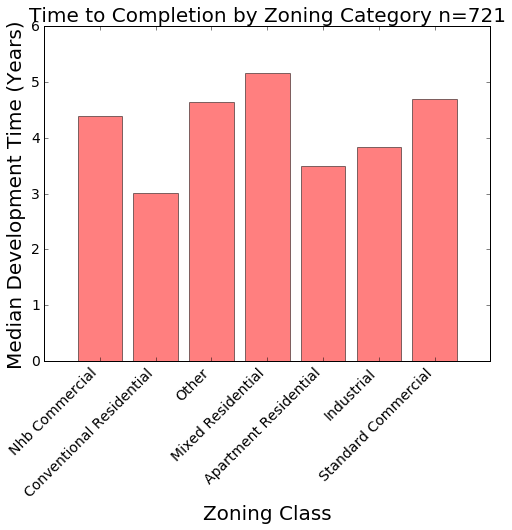

In [554]:
bar_graph('zone_class','project_time_years', 'Time to Completion by Zoning Category','Zoning Class', 'Median Development Time (Years)')

# Project Times by Years

In [555]:
df['year_start']=df['first_date'].str[0:4].astype(int)

In [556]:
year_medians=[]
for i in df['year_start'].value_counts(sort=False).index:
    median = df[df['year_start']==i]['project_time_years'].median()
    year_medians.append(median)

In [557]:
y_pos = np.arange(len(df['year_start'].value_counts(sort=False).index))

In [558]:
categories=[]
for cat in df['year_start'].value_counts(sort=False).index:
    categories.append(cat)

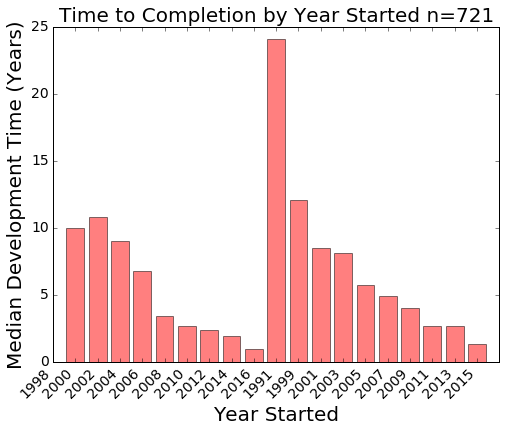

In [559]:
bar_graph('year_start','project_time_years', 'Time to Completion by Year Started','Year Started', 'Median Development Time (Years)')

In [563]:
df[df['dropped_out']==True]

,Unnamed: 0,BP_date,address,apn,best_date,best_stat,comp_date,con_date,dbi_permit,dropped_out,first_date,first_project_record_date,firstfiled,latest_project_record_date,latest_project_status,project_dates,project_duration_days,project_statuses,report_quarter,report_year,status,units,unitsnet,x,y,zoning,zoning_simplified,bp_duplicates,project_time_years,geometry,index_right,nhood,zone_class,year_start
2210,0,2008-02-08,1060 GILMAN AV,4937014,2010-11-04,BP REINSTATED,NaN,NaN,200610245911,True,2006-10-24,2008-02-08,2006-10-24,2010-11-04,BP REINSTATED,"('2008-02-08', '2008-02-08', '2008-02-08', '20...",NaN,"('BP ISSUED', 'BP ISSUED', 'BP ISSUED', 'BP IS...",1,2016,Building Permit Approved,1.0,1.0,-122.389150,37.719109,RH-1,RH-1,False,NaN,POINT (-122.38915 37.719108699),0,Bayview Hunters Point,Conventional Residential,2006
336,0,NaN,2800 ARELIOUS WALKER DR,4884026,2016-08-29,BP FILED,NaN,NaN,201608296272,True,2016-08-29,2016-08-29,2016-08-29,2016-08-29,BP FILED,"('2016-08-29',)",NaN,"('BP FILED',)",3,2016,Proposed,31.0,31.0,-122.386004,37.718986,RM-1,RM-1,False,NaN,POINT (-122.386004173 37.7189864949),0,Bayview Hunters Point,Industrial,2016
1085,0,NaN,490 JAMESTOWN AV (BLDG 3),5000001,2015-10-27,BP FILED,NaN,NaN,201510270913,True,2015-10-27,2015-10-27,2015-10-27,2015-10-27,BP FILED,"('2015-10-27', '2015-10-27', '2015-10-27')",NaN,"('BP FILED', 'BP FILED', 'BP FILED')",3,2016,Proposed,71.0,71.0,-122.385107,37.713344,P,P,False,NaN,POINT (-122.385106927 37.713344022),0,Bayview Hunters Point,Other,2015
2254,0,NaN,490 JAMESTOWN AV (BLDG 5),5000001,2015-10-27,BP FILED,NaN,NaN,201510270915,True,2015-10-27,2015-10-27,2015-10-27,2015-10-27,BP FILED,"('2015-10-27', '2015-10-27', '2015-10-27')",NaN,"('BP FILED', 'BP FILED', 'BP FILED')",3,2016,Proposed,58.0,58.0,-122.385107,37.713344,P,P,False,NaN,POINT (-122.385106927 37.713344022),0,Bayview Hunters Point,Other,2015
10,0,NaN,490 JAMESTOWN AV (BLDG 4),5000001,2015-10-27,BP FILED,NaN,NaN,201510270914,True,2015-10-27,2015-10-27,2015-10-27,2015-10-27,BP FILED,"('2015-10-27', '2015-10-27', '2015-10-27')",NaN,"('BP FILED', 'BP FILED', 'BP FILED')",3,2016,Proposed,81.0,81.0,-122.385107,37.713344,P,P,False,NaN,POINT (-122.385106927 37.713344022),0,Bayview Hunters Point,Other,2015
172,0,NaN,490 JAMESTOWN AV (BLDG 2),5000001,2015-10-27,BP FILED,NaN,NaN,201510270912,True,2015-10-27,2015-10-27,2015-10-27,2015-10-27,BP FILED,"('2015-10-27', '2015-10-27', '2015-10-27')",NaN,"('BP FILED', 'BP FILED', 'BP FILED')",3,2016,Proposed,63.0,63.0,-122.385107,37.713344,P,P,False,NaN,POINT (-122.385106927 37.713344022),0,Bayview Hunters Point,Other,2015
343,0,NaN,CANDLESTICK POINT (REMAINING),4884025,2014-04-10,PL APPROVED,NaN,NaN,NaN,True,2007-08-24,2014-04-10,2007-08-24,2014-04-10,PL APPROVED,"('2014-04-10',)",NaN,"('PL APPROVED',)",4,2016,Proposed,9579.0,9579.0,-122.384934,37.719383,P,P,True,NaN,POINT (-122.384934383 37.7193826411),0,Bayview Hunters Point,Other,2007
1576,0,NaN,HUNTERS POINT EXPY,4886008,2010-08-03,PL APPROVED,NaN,NaN,NaN,True,2007-08-24,2007-12-03,2007-08-24,2010-08-03,PL APPROVED,"('2007-12-03', '2007-12-03', '2007-12-03', '20...",NaN,"('PL FILED', 'PL FILED', 'PL FILED', 'PL FILED...",3,2015,Proposed,10237.0,10237.0,-122.380302,37.714688,P,P,True,NaN,POINT (-122.380302389 37.7146878859),0,Bayview Hunters Point,Other,2007
1887,0,2013-06-26,227 WEST POINT ROAD,4624009,2013-06-26,PL FILED,NaN,NaN,201302079710,True,2007-02-14,2008-06-12,2007-02-14,2013-06-26,PL FILED,"('2008-06-12', '2008-12-10', '2008-12-10', '20...",NaN,"('PL APPROVED', 'PL APPROVED', 'PL APPROVED', ...",3,2013,Proposed,54.0,54.0,-122.379131,37.735080,RH-2,RH-2,False,NaN,POINT (-122.379131 37.73508),0,Bayview Hunters Point,Conventional Residential,2007
515,0,NaN,900 INNES AVE,4646020,2004-09-17,PL FILED,NaN,NaN,NaN,True,2004-09-17,2004-09-17,2004-09-17,2004-09-17,PL FILED,"('2004-09-17',)",NaN,"('PL FILED',)",3,2009,Proposed,128.0,128.0,-122.376894,37.732734,NC-2,NC-2,True,NaN,POINT (-122.376894 37.732734),0,Bayview Hunters Point

# Figure 1. Histograms

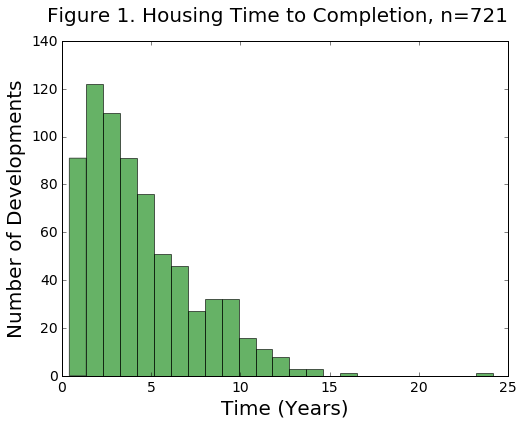

In [510]:
plt.figure(1, figsize=(8,6), )
plt.suptitle('Figure 1. Housing Time to Completion,' + ' n='+str(df[pd.notnull(df['project_time_years'])].count()['project_time_years']), fontsize=20)
plt.xlabel('Time (Years)', fontsize = 20)
plt.ylabel('Number of Developments', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
ax = plt.hist(df[pd.notnull(df['project_time_years'])]['project_time_years'], bins=25, alpha=.6, color='g')
plt.savefig(output+'hitogram.png')
plt.show()

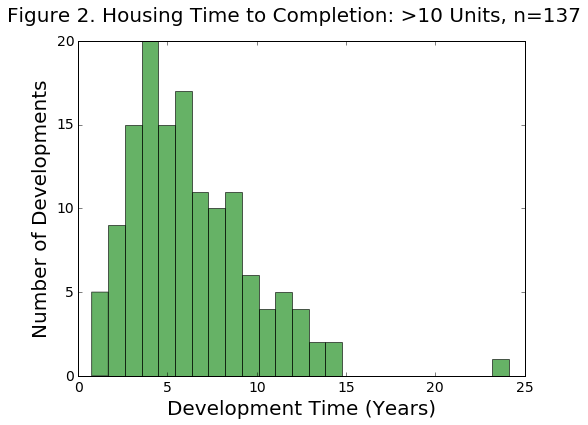

In [511]:
plt.figure(1, figsize=(8,6), )
plt.suptitle('Figure 2. Housing Time to Completion: >10 Units,'+ ' n='+str(df_big[pd.notnull(df_big['project_time_years'])].count()['project_time_years']), fontsize=20)
plt.xlabel('Development Time (Years)', fontsize = 20)
plt.ylabel('Number of Developments', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
ax = plt.hist(df_big[pd.notnull(df_big['project_time_years'])]['project_time_years'], bins=25, alpha=.6, color='g')
plt.savefig(output+'hitogram_big_proj.png')
plt.show()

In [512]:
df_big['project_time_years'].describe()

count    137.000000
mean       6.255254
std        3.453810
min        0.750685
25%        3.854795
50%        5.945205
75%        8.273973
max       24.128767
Name: project_time_years, dtype: float64

# Figure 2. Years Per Unit Histogram

In [513]:
# Project review time, normalized by amount of units
#create unit-year category so that we normalize by units when comparing geographies
df['years_per_unit']=df['project_time_years']/df['units']

In [514]:
df['years_per_unit'].describe()

count    721.000000
mean       2.564254
std        2.491997
min        0.006109
25%        0.756164
50%        1.923288
75%        3.616438
max       13.243836
Name: years_per_unit, dtype: float64

In [515]:
df.sort_values('years_per_unit', ascending = False)[0:5]

,Unnamed: 0,BP_date,address,apn,best_date,best_stat,comp_date,con_date,dbi_permit,first_date,first_project_record_date,firstfiled,latest_project_record_date,latest_project_status,project_dates,project_duration_days,project_statuses,report_quarter,report_year,status,units,unitsnet,x,y,zoning,zoning_simplified,bp_duplicates,project_time_years,geometry,index_right,nhood,zone_class,year_start,years_per_unit
186,12833,NaN,1245 DOLORES ST,6534024,2006-11-30,CONSTRUCTION,10/01/2013,2006-11-30,200007074553,2000-07-07,2006-11-30,2000-07-07,2006-11-30,CONSTRUCTION,"('2006-11-30', '2006-11-30', '2006-11-30', '20...",4834.0,"('CONSTRUCTION', 'CONSTRUCTION', 'CONSTRUCTION...",3,2013,Under Construction,1.0,1.0,-122.424732,37.749343,RH-3,RH-3,False,13.243836,POINT (-122.424732 37.749343),18,Mission,Conventional Residential,2000,13.243836
2814,21967,2009-08-07,652 LAKEVIEW AV,7016023,2013-06-24,CONSTRUCTION,01/01/2016,2013-06-24,200311240936,2003-11-24,2009-08-07,2003-11-24,2013-06-24,CONSTRUCTION,"('2009-08-07', '2009-08-07', '2009-08-07', '20...",4421.0,"('BP APPROVED', 'BP APPROVED', 'BP APPROVED', ...",4,2015,Under Construction,1.0,1.0,-122.457741,37.718436,RH-1,RH-1,False,12.112329,POINT (-122.457740668 37.7184362783),23,Oceanview/Merced/Ingleside,Conventional Residential,2003,12.112329
1878,21973,2010-04-13,23 SPARTA ST,6176011,2015-12-10,CONSTRUCTION,01/01/2016,2015-05-18,200401063464,2004-01-06,2004-01-06,2004-01-06,2015-12-10,CONSTRUCTION,"('2004-01-06', '2010-04-13', '2010-06-04', '20...",4378.0,"('BP FILED', 'BP APPROVED', 'BP ISSUED', 'BP I...",4,2015,Under Construction,1.0,1.0,-122.403330,37.717794,RH-1,RH-1,False,11.994521,POINT (-122.403329904 37.7177938414),38,Visitacion Valley,Conventional Residential,2004,11.994521
2929,21835,2009-02-09,1310 STANYAN ST,2706035,2012-07-05,CONSTRUCTION,01/01/2016,2010-12-07,200407158977,2004-07-15,2009-02-09,2004-07-15,2012-07-05,CONSTRUCTION,"('2009-02-09', '2009-02-09', '2009-02-09', '20...",4187.0,"('BP APPROVED', 'BP APPROVED', 'BP APPROVED', ...",4,2015,Under Construction,1.0,1.0,-122.451007,37.758409,RH-1(D),RH-1(D),False,11.471233,POINT (-122.451006674 37.758409222),37,Twin Peaks,Conventional Residential,2004,11.471233
1526,27389,2015-01-26,4126 17TH ST,2623028,2016-07-29,CONSTRUCTION,01/01/2017,2016-07-29,201405307098,2005-12-08,2005-12-08,2005-12-08,2016-07-29,CONSTRUCTION,"('2005-12-08', '2005-12-08', '2005-12-08', '20...",4042.0,"('BP FILED', 'BP FILED', 'BP FILED', 'BP FILED...",4,2016,Under Construction,1.0,1.0,-122.437954,37.762612,RH-3,RH-3,False,11.073973,POINT (-122.437954318 37.7626118963),2,Castro/Upper Market,Conventional Residential,2005,11.073973


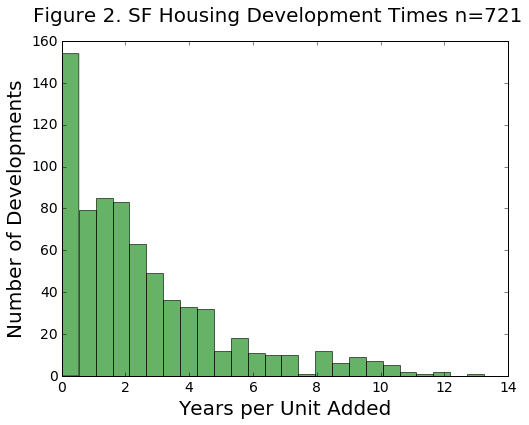

In [516]:
plt.figure(1, figsize=(8,6), )
plt.suptitle('Figure 2. SF Housing Development Times' + ' n='+str(df[pd.notnull(df['years_per_unit'])].count()['years_per_unit']), fontsize=20)
plt.xlabel('Years per Unit Added', fontsize=20)
plt.ylabel('Number of Developments', fontsize=20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
ax = plt.hist(df[pd.notnull(df['years_per_unit'])]['years_per_unit'], bins=25, alpha=.6, color='g')
plt.savefig(output+'hitogram_yearunits.png')
plt.show()

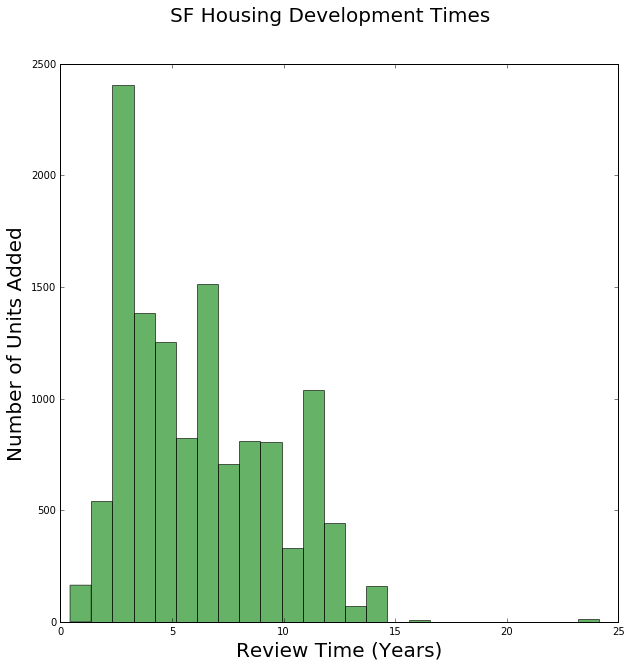

In [517]:
#Create dataset units added by years for each unit
list = []
uniqueid = 0
for index, row in df.iterrows():
    amount = int(row['units'])
    for units in range(0, amount):
        dictionary = {}
        dictionary['id']=uniqueid+1
        dictionary['time']=row['project_time_years']
        list.append(dictionary)
        uniqueid=uniqueid+1
df_units = pd.DataFrame(list)

plt.figure(1, figsize=(10,10), )
plt.suptitle('SF Housing Development Times', fontsize=20)
plt.xlabel('Review Time (Years)', fontsize = 20)
plt.ylabel('Number of Units Added', fontsize = 20)
ax = plt.hist(df_units[pd.notnull(df_units['time'])]['time'], bins=25, alpha=.6, color='g')
plt.savefig(output+'hitogram_units.png')
plt.show()

In [518]:
df_units['time'].describe()

count    12463.000000
mean         6.204317
std          3.362512
min          0.430137
25%          3.364384
50%          5.947945
75%          8.665753
max         24.128767
Name: time, dtype: float64

# Figure 4. Scatter Plots

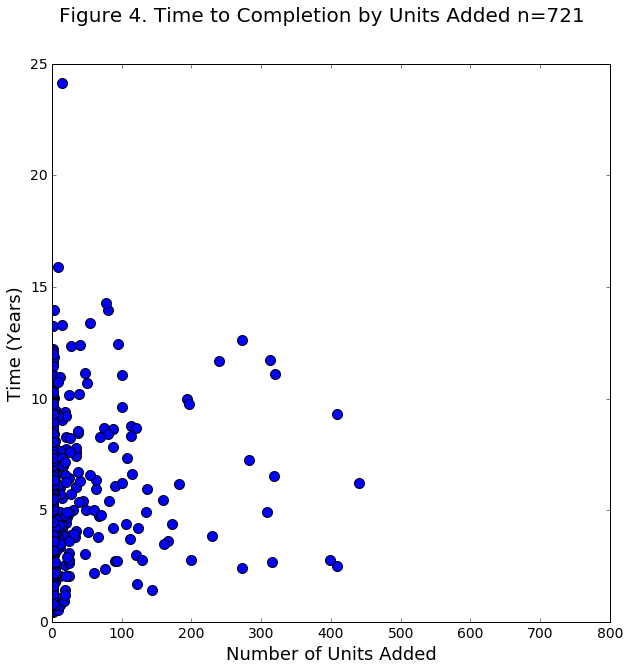

In [519]:
plt.figure(1, figsize=(10,10))
plt.scatter(df['units'], df['project_time_years'], s=100)
plt.suptitle('Figure 4. Time to Completion by Units Added' + ' n='+str(df[pd.notnull(df['project_time_years'])].count()['project_time_years']), fontsize=20)
plt.ylabel('Time (Years)', fontsize = 18)
plt.xlabel('Number of Units Added', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize = 14)
plt.xlim([0,800])
plt.ylim([0,25])
plt.savefig(output+'scatter.png')

(0, 25)

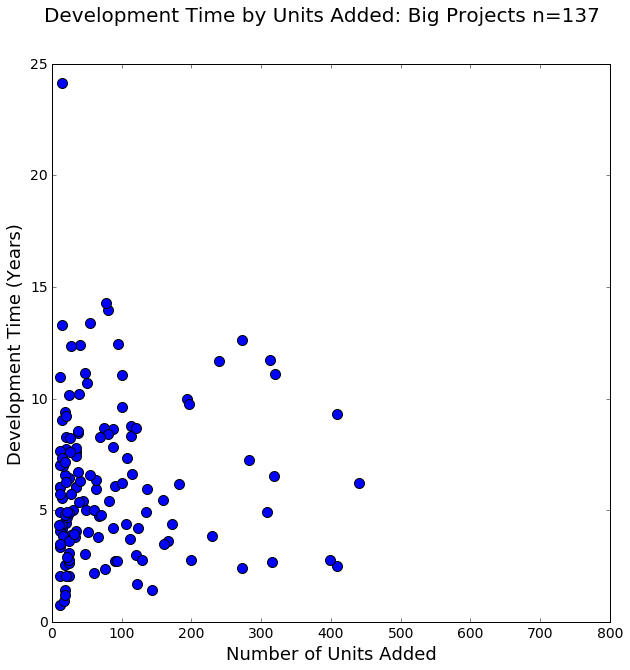

In [520]:
plt.figure(1, figsize=(10,10))
plt.scatter(df_big['units'], df_big['project_time_years'], s=100)
plt.suptitle('Development Time by Units Added: Big Projects' + ' n='+str(df_big[pd.notnull(df_big['project_time_years'])].count()['project_time_years']), fontsize=20)
plt.ylabel('Development Time (Years)', fontsize = 18)
plt.xlabel('Number of Units Added', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize = 14)
plt.xlim([0,800])
plt.ylim([0,25])

# Figure 5. Plot by unit category

In [521]:
unit_cutoffs=[10, 50, 100, 200]
def unit_categories(value):
    if value['units'] <unit_cutoffs[0]:
        field = '0'+'-'+str(unit_cutoffs[0])
    elif (value['units'] >=unit_cutoffs[0]) & (value['units'] <unit_cutoffs[1]):
        field = str(unit_cutoffs[0])+'-'+str(unit_cutoffs[1])
    elif (value['units']>= unit_cutoffs[1]) & (value['units'] <unit_cutoffs[2]):
        field = str(unit_cutoffs[1])+'-'+str(unit_cutoffs[2])
    elif (value['units']>= unit_cutoffs[2]) & (value['units'] <200):
        field = str(unit_cutoffs[2])+'-'+str(unit_cutoffs[3])
    elif value['units']>=200:
        field = '>'+str(unit_cutoffs[3])
    return field
    
df['unitcat']=df.apply(unit_categories, axis=1)
df_big['unitcat']=df_big.apply(unit_categories, axis=1)

/Users/briangoggin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [522]:
df['unitcat'].value_counts()

0-10       1922
10-50       246
50-100      116
100-200      96
>200         94
Name: unitcat, dtype: int64

In [523]:
#bar_graph('unitcat','project_time_years', 'Time to Completion by Size Category','Size (Units)', 'Time (Years)')

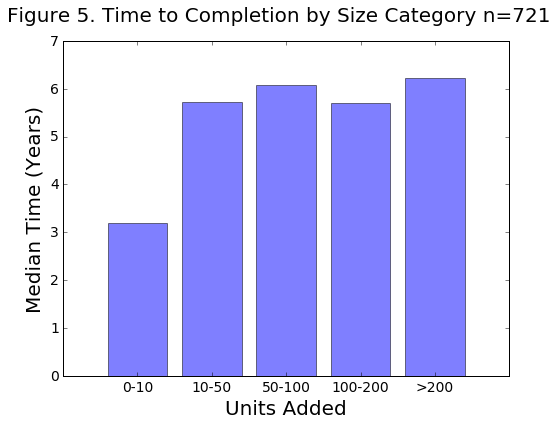

In [524]:
cat_medians=[]
categories=['0-10', '10-50', '50-100', '100-200', '>200']
for cat in categories:
    median = df[df['unitcat']==cat]['project_time_years'].median()
    cat_medians.append(median)
objects = df['unitcat'].unique()
y_pos = np.arange(len(objects))

plt.figure(1, figsize=(8,6), )
plt.suptitle('Figure 5. Time to Completion by Size Category' + ' n='+str(df[pd.notnull(df['project_time_years'])].count()['project_time_years']), fontsize=20)
plt.ylabel('Median Time (Years)', fontsize=20)
plt.xlabel('Units Added', fontsize=20)
plt.bar(y_pos, cat_medians, align='center', alpha=0.5)
plt.xticks(y_pos, categories, fontsize=14)
plt.yticks(fontsize = 14)
plt.savefig(output+'bar_chart_times.png')
plt.show()

# Figures 3 and 6. Breakdown time by stage of process

In [525]:
df.shape

(2474, 35)

In [526]:
#in order to use as much data as possible, I am not keeping all data and just creating time vars where we can (i.e. where they are nonnull)
def permit_time(value):
    returnval=np.nan
    if pd.notnull(value['BP_date']) & pd.notnull(value['first_date']):
        returnval=((dateutil.parser.parse(value['BP_date']) - dateutil.parser.parse(value['first_date'])).days)/365
    return returnval
def bp_time(value):
    returnval=np.nan
    if pd.notnull(value['con_date']) & pd.notnull(value['BP_date']):
        returnval=((dateutil.parser.parse(value['con_date']) - dateutil.parser.parse(value['BP_date'])).days)/365
    return returnval
def con_time(value):
    returnval=np.nan
    if pd.notnull(value['comp_date']) & pd.notnull(value['con_date']):
        returnval=((dateutil.parser.parse(value['comp_date']) - dateutil.parser.parse(value['con_date'])).days)/365
    return returnval
    
df['permit_time']=df.apply(permit_time, axis=1)
df['bp_time']=df.apply(bp_time, axis=1)
df['con_time']=df.apply(con_time, axis=1)

In [527]:
#Final sample with at least one nonmissing piece of relevant information. leaving other observations in because they don't affect graphs anyway
df[(pd.isnull(df['con_time'])) & (pd.isnull(df['permit_time'])) & (pd.isnull(df['bp_time'])) & (pd.isnull(df['project_time_years']))].shape

(1147, 38)

In [445]:
df['permit_time'].describe()

count    1089.000000
mean        2.113790
std         2.035939
min         0.002740
25%         0.819178
50%         1.476712
75%         2.575342
max        13.934247
Name: permit_time, dtype: float64

In [446]:
df['bp_time'].describe()

count    650.000000
mean       1.116902
std        1.218792
min        0.054795
25%        0.417123
50%        0.704110
75%        1.286301
max        7.717808
Name: bp_time, dtype: float64

In [447]:
df['con_time'].describe()

count    721.000000
mean       1.232257
std        1.382572
min        0.000000
25%        0.427397
50%        0.816438
75%        1.473973
max        8.810959
Name: con_time, dtype: float64

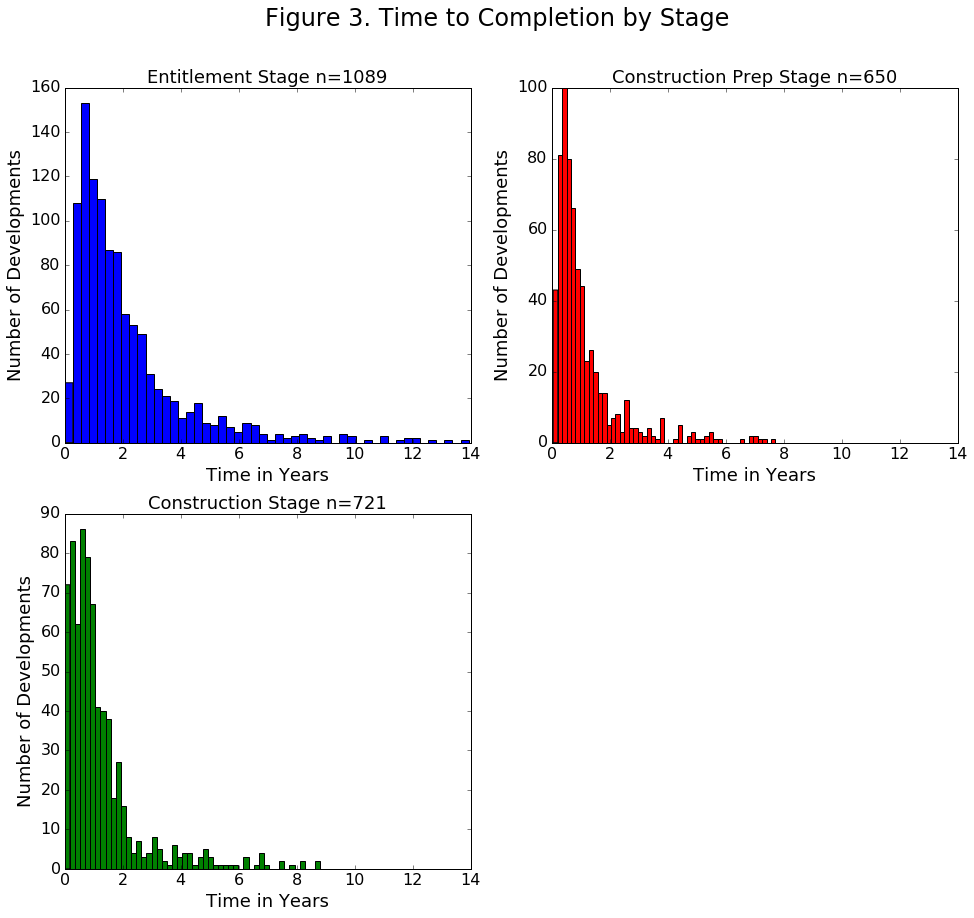

In [448]:
plt.figure(1, figsize=(16,14), )
plt.suptitle("Figure 3. Time to Completion by Stage", fontsize=24)

ax = plt.subplot(221)
ax.set_title("Entitlement Stage,"+ ' n='+str(df[pd.notnull(df['permit_time'])].count()['permit_time']), fontsize=18)
ax.set_xlabel('Time in Years', fontsize=18)
ax.set_ylabel('Number of Developments', fontsize=18)
plt.xlim([0,14])
#plt.ylim([0,80])
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
ax.hist(df[pd.notnull(df['permit_time'])]['permit_time'], bins=50, color='b')

ax = plt.subplot(222)
ax.set_title("Construction Prep Stage," + ' n='+str(df[pd.notnull(df['bp_time'])].count()['bp_time']), fontsize=18)
ax.set_xlabel('Time in Years', fontsize=18)
ax.set_ylabel('Number of Developments', fontsize=18)
plt.xlim([0,14])
#plt.ylim([0,80])
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
ax.hist(df[pd.notnull(df['bp_time'])]['bp_time'], bins=50, color='r')

ax = plt.subplot(223)
ax.set_title("Construction Stage,"+ ' n='+str(df[pd.notnull(df['con_time'])].count()['con_time']), fontsize=18)
ax.set_xlabel('Time in Years', fontsize=18)
ax.set_ylabel('Number of Developments', fontsize=18)
plt.xlim([0,14])
#plt.ylim([0,80])
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
ax.hist(df[pd.notnull(df['con_time'])]['con_time'], bins=50, color='g')

plt.savefig(output+'big_hist.png')

In [449]:
ent_medians=[]
bp_medians=[]
cons_medians=[]
ent_number=0
bp_number=0
cons_number=0
categories=['0-10', '10-50', '50-100', '100-200', '>200']
for cat in categories:
    median1 = df[df['unitcat']==cat]['permit_time'].median()
    median2 = df[df['unitcat']==cat]['bp_time'].median()
    median3 = df[df['unitcat']==cat]['con_time'].median()
    ent_number=ent_number+df[df['unitcat']==cat]['permit_time'].count() #count sample size for non-missing y variable
    bp_number=bp_number+df[df['unitcat']==cat]['bp_time'].count()
    cons_number=cons_number+df[df['unitcat']==cat]['con_time'].count()
    
    ent_medians.append(median1)
    bp_medians.append(median2)
    cons_medians.append(median3)
objects = df['unitcat'].unique()
y_pos = np.arange(len(objects))

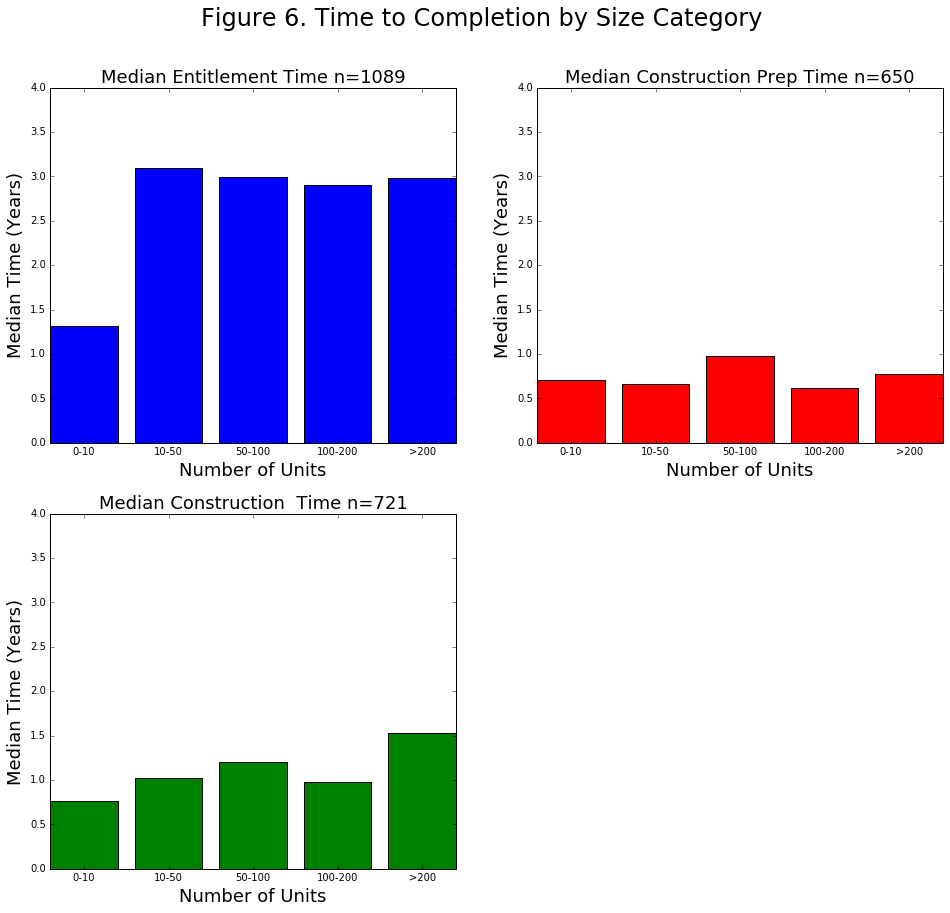

In [450]:
plt.figure(1, figsize=(16,14), )
plt.suptitle("Figure 6. Time to Completion by Size Category", fontsize=24)

ax = plt.subplot(221)
ax.set_title('Median Entitlement Time'+' n='+str(ent_number), fontsize=18)
ax.set_xlabel('Number of Units', fontsize=18)
ax.set_ylabel('Median Time (Years)', fontsize=18)
ax.set_xticks(y_pos)
ax.set_xticklabels(categories)
ax.set_ylim([0,4])
ax.bar(y_pos, ent_medians, align='center', color='b')

ax = plt.subplot(222)
ax.set_title('Median Construction Prep Time'+' n='+str(bp_number), fontsize=18)
ax.set_xlabel('Number of Units', fontsize=18)
ax.set_ylabel('Median Time (Years)', fontsize=18)
ax.set_xticks(y_pos)
ax.set_xticklabels(categories)
ax.set_ylim([0,4])
ax.bar(y_pos, bp_medians, align='center', color='r')

ax = plt.subplot(223)
ax.set_title('Median Construction  Time'+' n='+str(cons_number), fontsize=18)
ax.set_xlabel('Number of Units', fontsize=18)
ax.set_ylabel('Median Time (Years)', fontsize=18)
ax.set_xticks(y_pos)
ax.set_xticklabels(categories)
ax.set_ylim([0,4])
ax.bar(y_pos, cons_medians, align='center', color='g')

plt.savefig(output+'big_bar.png')

# Figures 7 and 8. Create Neighborhood Graphs

In [451]:
# for these graphs, drop if neighborhood has sample with non-missing BP date less than 10. Brings sample for completed projects down to 692
for nhood in df['nhood'].value_counts().index:
    if df[df['nhood']==nhood]['BP_date'].count() <10:
        df=df[df['nhood']!=nhood]

In [452]:
df['ptime_unityears']=df['permit_time']/df['units']

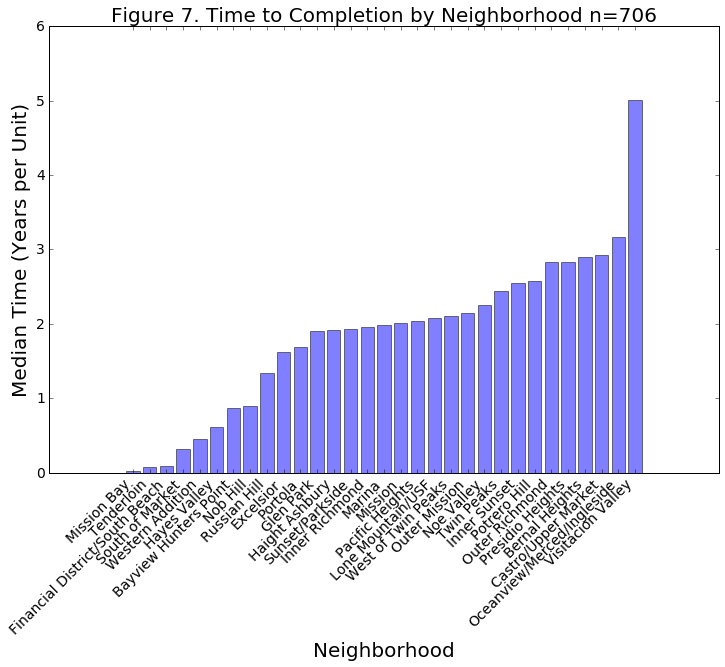

In [453]:
graph_options=['b', (12, 8)]
bar_graph('nhood','years_per_unit', 'Figure 7. Time to Completion by Neighborhood', 'Neighborhood', 'Median Time (Years per Unit)', df, True, graph_options)

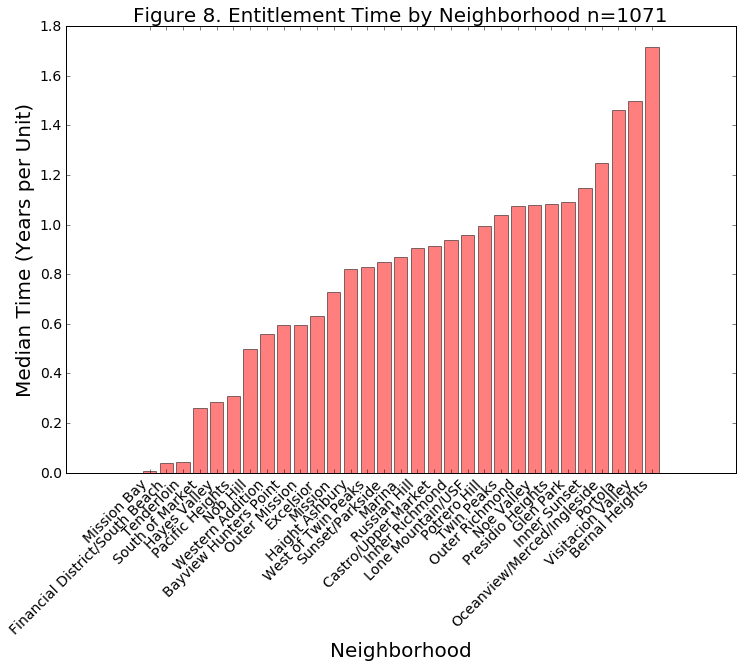

In [454]:
graph_options=['r', (12, 8)]
bar_graph('nhood','ptime_unityears', 'Figure 8. Entitlement Time by Neighborhood', 'Neighborhood', 'Median Time (Years per Unit)', df, True, graph_options)

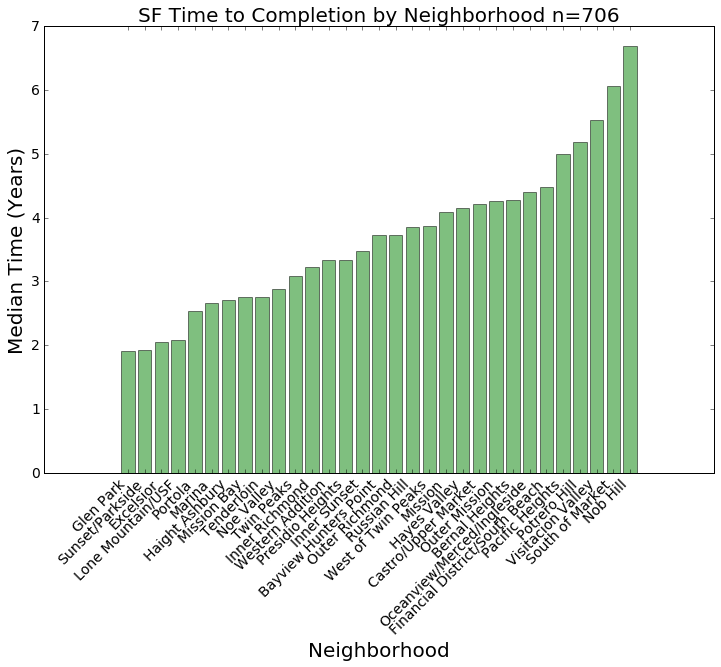

In [455]:
graph_options=['g', (12, 8)]
bar_graph('nhood','project_time_years', 'SF Time to Completion by Neighborhood', 'Neighborhood', 'Median Time (Years)', df, True, graph_options)

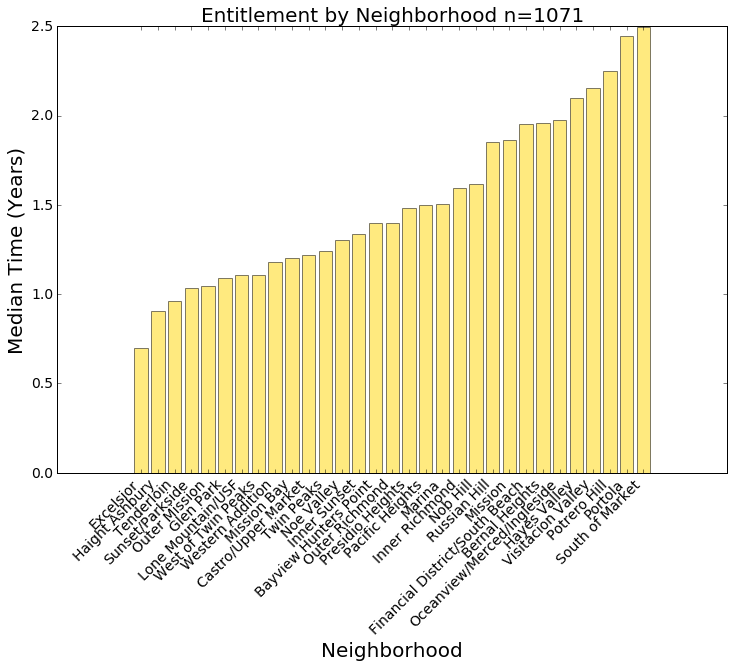

In [456]:
graph_options=['gold', (12, 8)]
bar_graph('nhood','permit_time', 'Entitlement by Neighborhood', 'Neighborhood', 'Median Time (Years)', df, True, graph_options)

In [564]:
print (type(df))

<class 'geopandas.geodataframe.GeoDataFrame'>


# Maps
Ideas: Map of dots colored by time to completion with SF basemap in the background. Then chloropleth map that averages times by some geography.

In [587]:
%matplotlib inline
from cartoframes import CartoContext, Credentials
import geopandas as gpd
import pandas as pd

In [588]:
# set carto credentials
creds = Credentials(key='326c2299e8d630c6785cfebb108a41454d50bd51', 
                    username='bgoggin')
creds.save()
cxn = CartoContext()

In [589]:
# read from CSV from another user account using CARTO's SQL API
df = pd.read_csv('https://eschbacher.carto.com/api/v2/sql?q=SELECT+*+FROM+nat&format=csv').set_index('cartodb_id')


In [590]:
# write this dataset to your CARTO account
#cxn.write(df, 'nat')

# download it and decode geometries
df = cxn.read('nat', decode_geom=True)

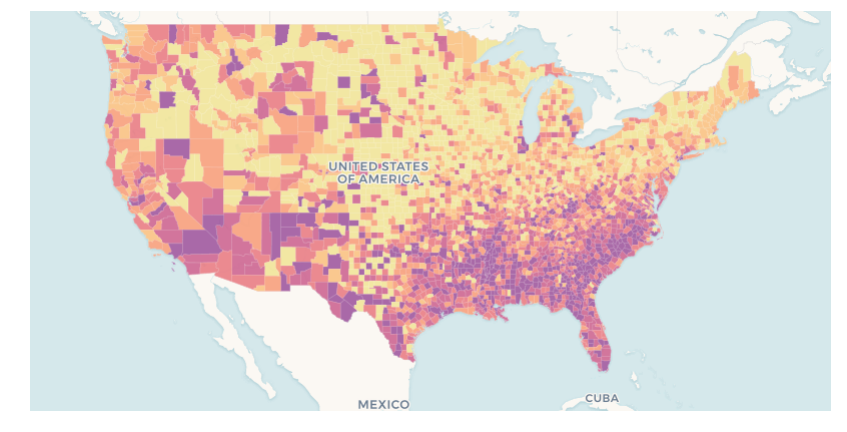

In [592]:
from cartoframes import Layer, styling
cxn.map(layers=Layer('nat', color={'column': 'hr90',
                                   'scheme': styling.sunset(7),
                                  'legend': 'Blah blah'}),
        interactive=False)

In [579]:
#Cartoframes
from cartoframes import Layer, BaseMap, styling

In [ ]:
cc = cartoframes.CartoContext(base_url=BASEURL,
                              api_key=APIKEY)
cc.map(layers=[BaseMap('light'),
               Layer('acadia_biodiversity',
                     color={'column': 'simpson_index',
                            'scheme': styling.tealRose(5)}),
               Layer('peregrine_falcon_nest_sites',
                     size='num_eggs',
                     color={'column': 'bird_id',
                            'scheme': styling.vivid(10)})],
       interactive=True)

In [576]:
#Matplolib
#df.plot(column='ptime_unityears, cmap='jet')
#ax=base, column='min_dist_to_bart', cmap='jet', marker='o', fillstyle='full', markeredgewidth=0.0, markersize=.5, alpha=.5)

SyntaxError: invalid syntax (<ipython-input-576-a5ea6fb8316a>, line 1)